# Clustering

- filter raccoons and get 0-15
- apply K-means, use interaction time in the distance matrix
- evaluate with silhouette index.

In [1]:
import glob
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [2]:
# Silhouette:
# The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.

In [3]:
def preprocess(g):
    # Filtering: remove edges > 15
    remove = [node for node in g.nodes if int(node) > 15]
    g.remove_nodes_from(remove)

    # the distance is the inverse of the interaction
    # take log because the interaction values have a big range
    A = nx.to_numpy_matrix(g)
    X = 1/(1+np.log(A + 1))
    np.fill_diagonal(X, 0)
    return X


def plot_spring(g, labels):
    plt.figure()
    ax1 = plt.subplot(111)
    
    gn_pos = nx.spring_layout(g)
    g1 = nx.draw_networkx_nodes(g, gn_pos, node_color=labels, node_size=500, label=labels)
    nx.draw_networkx_edges(g, gn_pos, alpha=0.2)
    
    plt.axis('off')
    legend1 = ax1.legend(*g1.legend_elements(), title="Classes")
    ax1.add_artist(legend1)
    plt.show()

    
def cluster_score(X, g):
    scores = []
    labels = []
    for i in range(2, len(X)):
        kmeans_model = KMeans(n_clusters=i, precompute_distances=True).fit(X)
        l = kmeans_model.labels_
        s = silhouette_score(X, l, metric="precomputed")
        scores.append(s)
        labels.append(l)
    
    idx = np.argmax(scores)
    clust_lab = labels[idx]
    plot_spring(g, clust_lab)
    return clust_lab, scores[idx], np.asarray(scores), np.asarray(labels)

In [4]:
dir_name = '../raccoon_proximity_weighted/weighted_raccoon_matrix_*.graphml'
files = glob.glob(dir_name)

files = [(int(f.split('_')[5].split('.')[0]), f) for f in files]

files.sort()

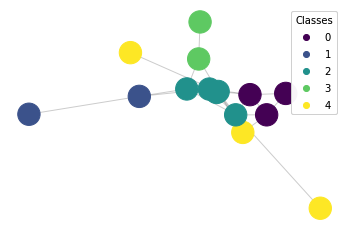

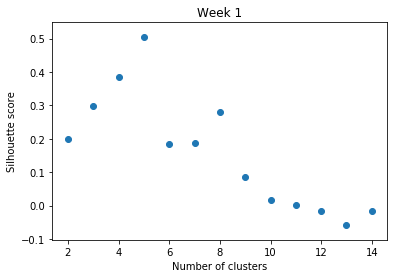

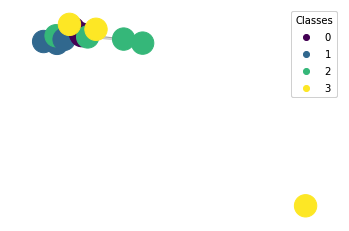

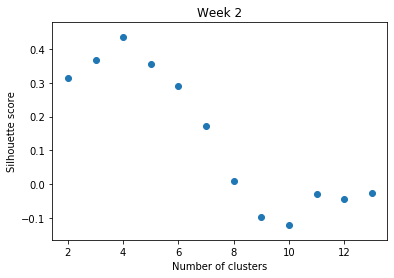

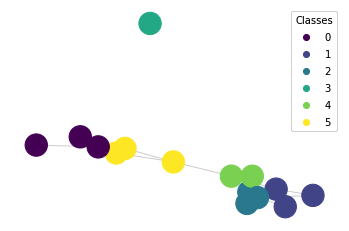

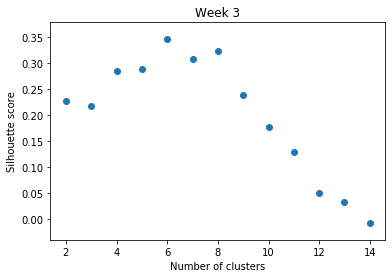

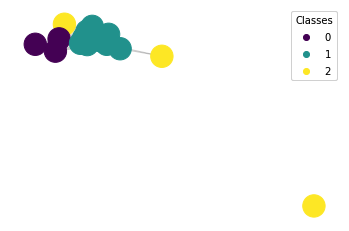

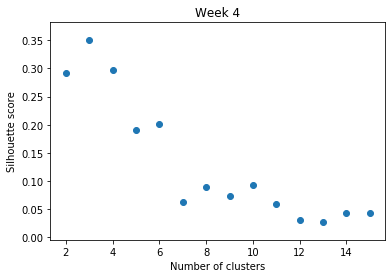

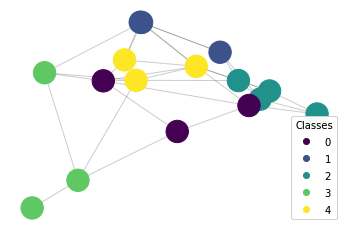

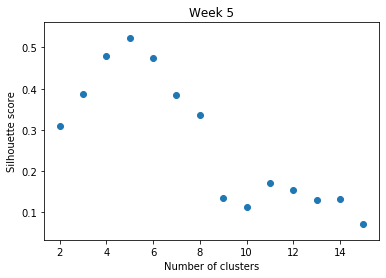

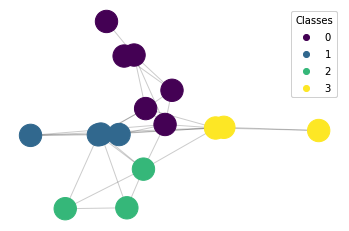

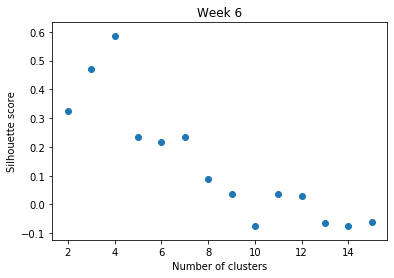

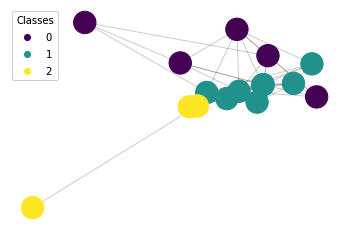

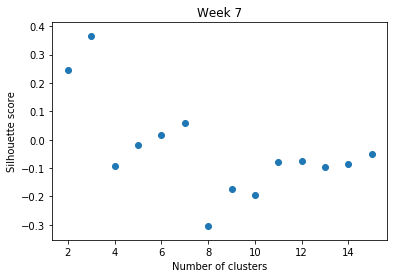

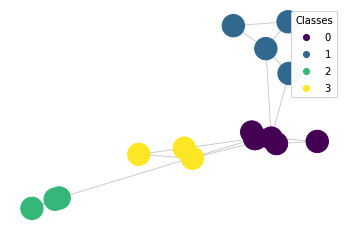

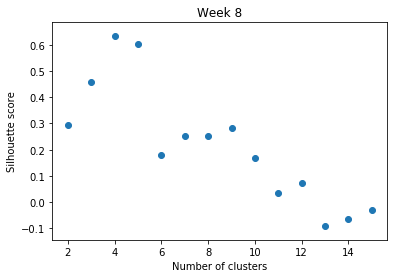

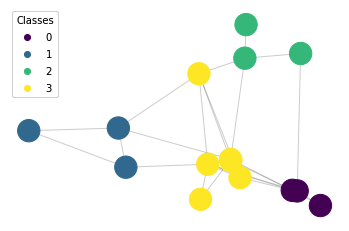

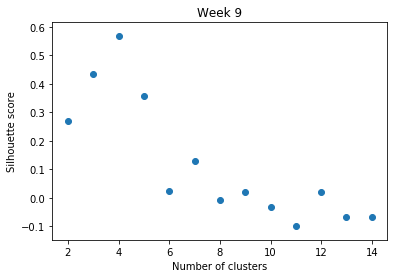

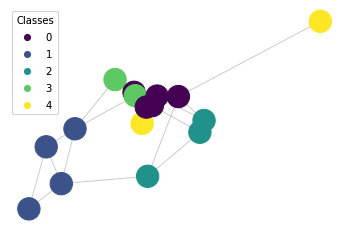

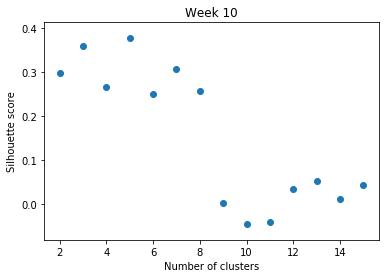

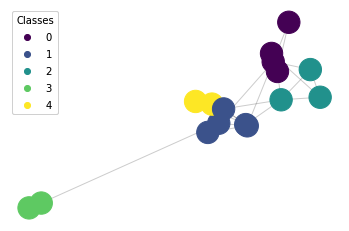

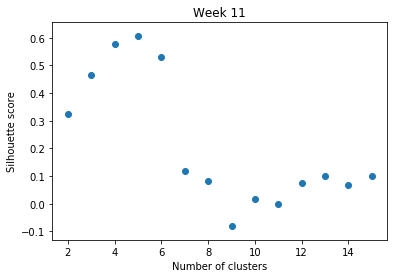

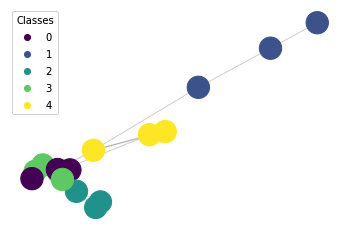

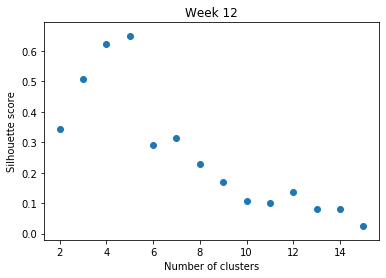

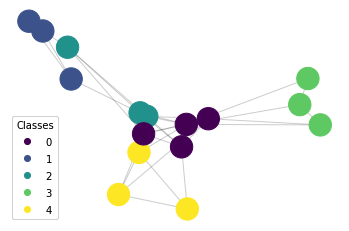

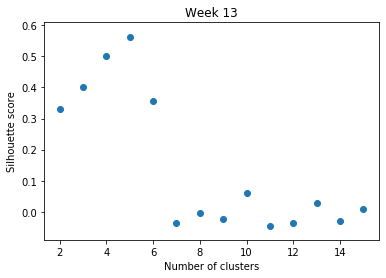

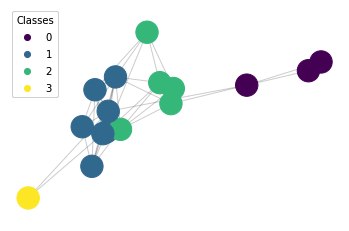

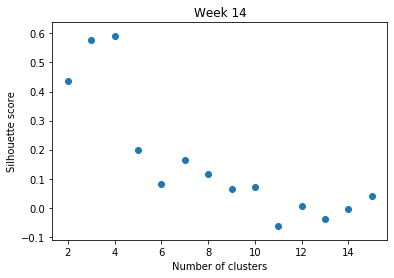

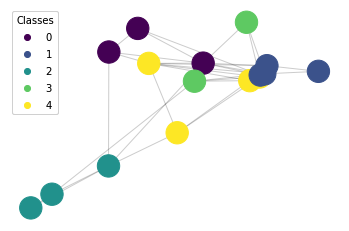

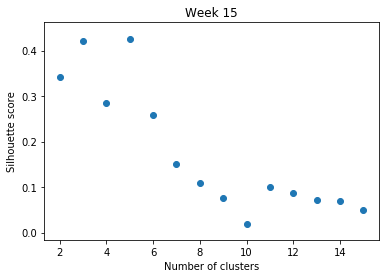

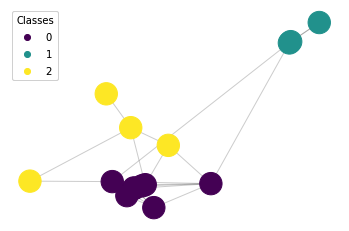

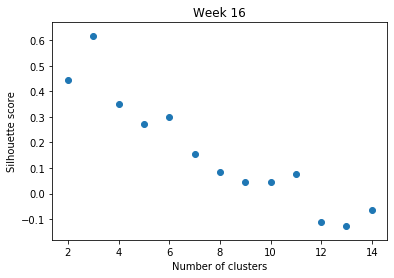

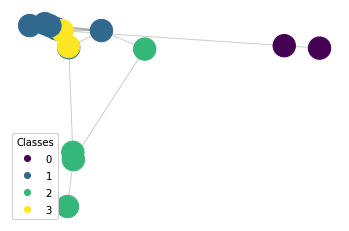

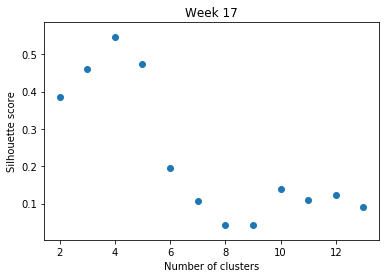

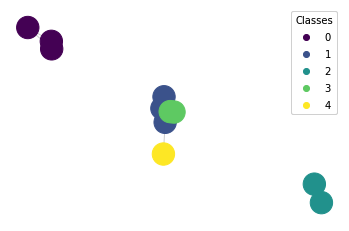

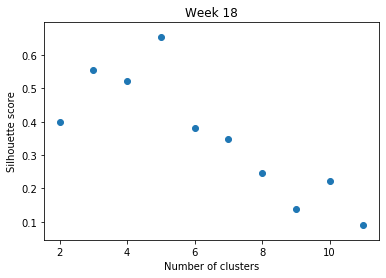

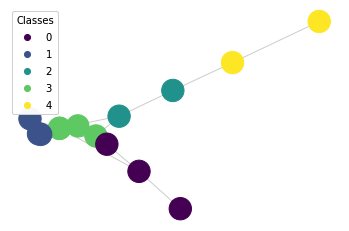

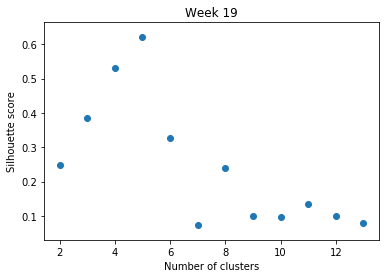

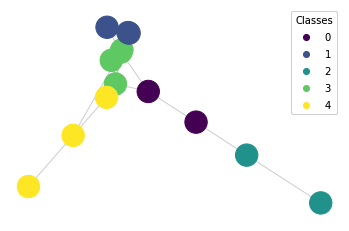

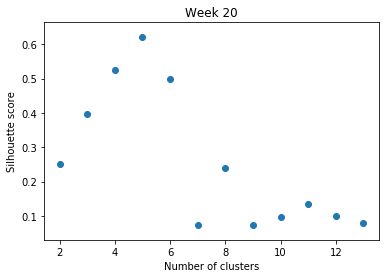

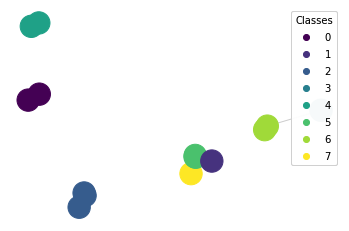

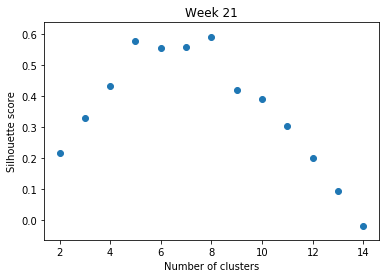

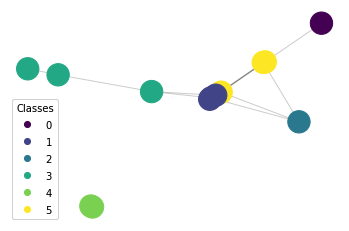

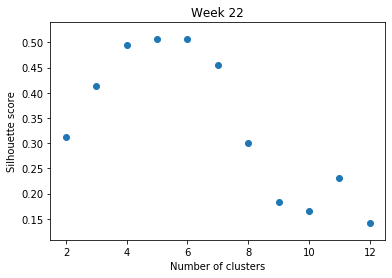

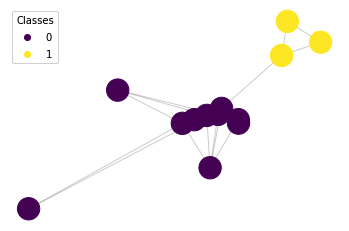

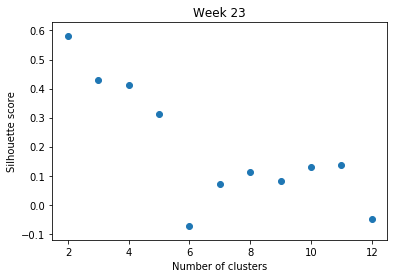

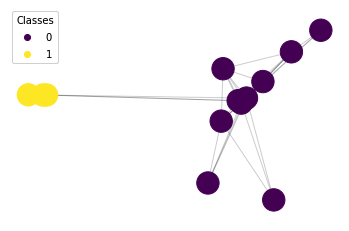

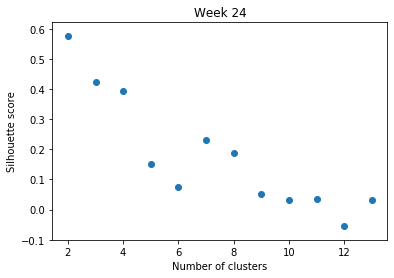

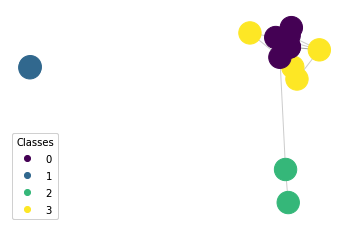

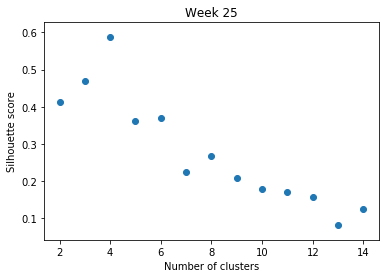

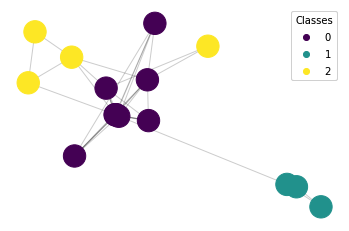

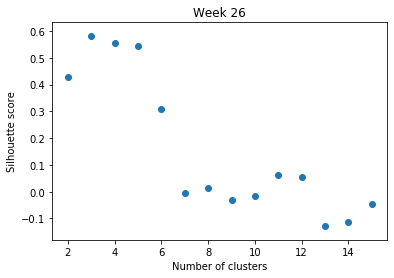

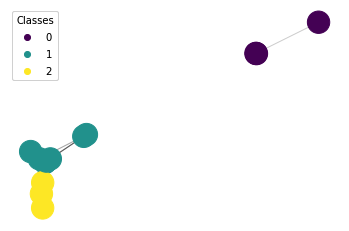

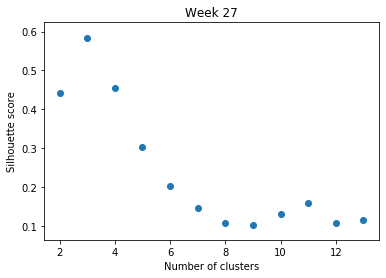

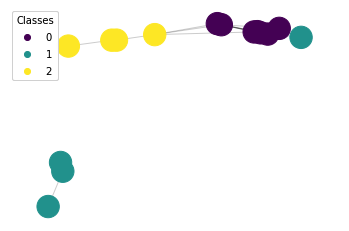

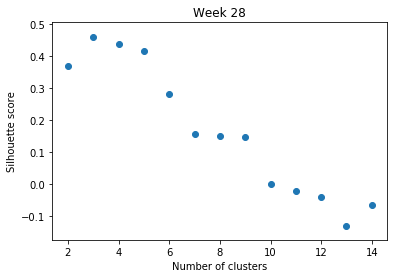

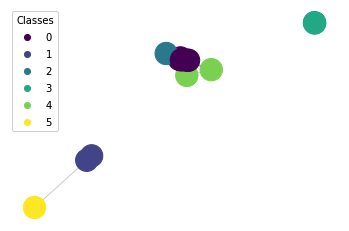

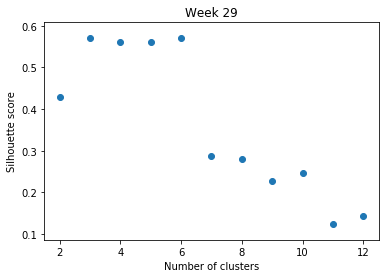

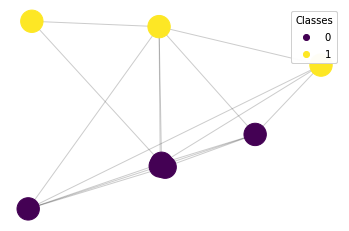

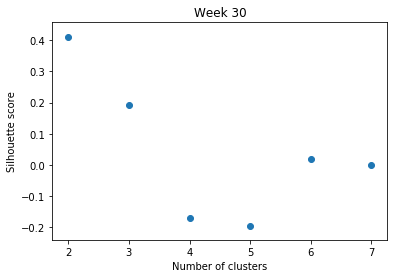

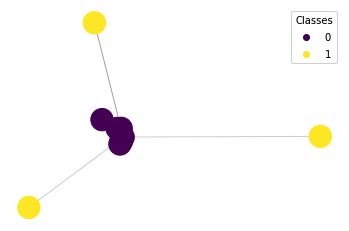

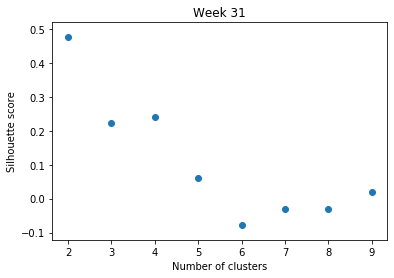

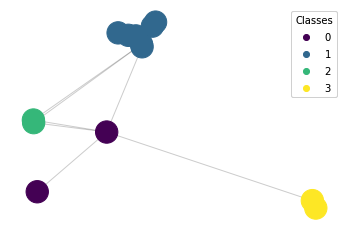

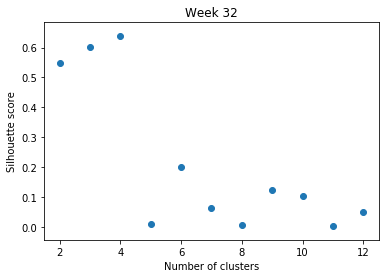

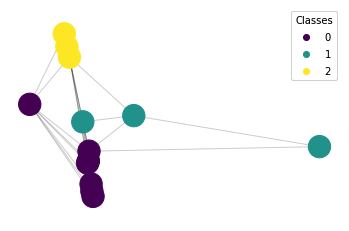

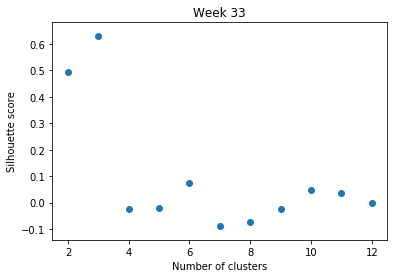

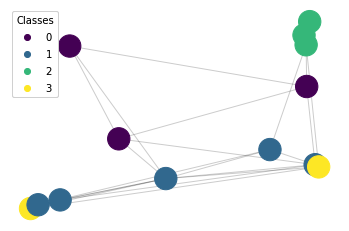

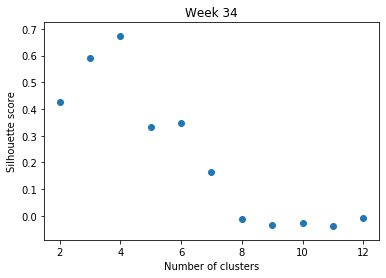

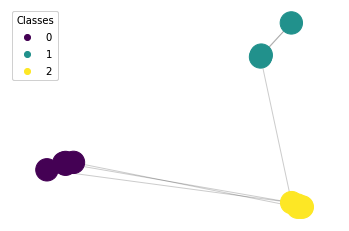

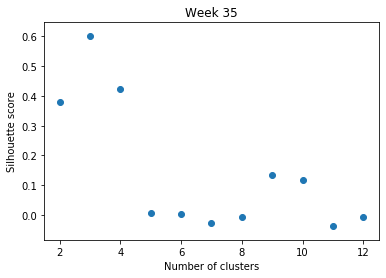

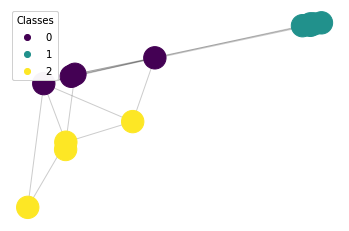

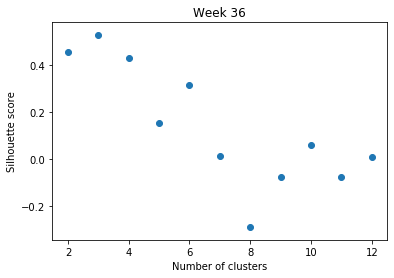

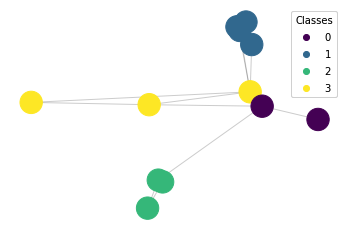

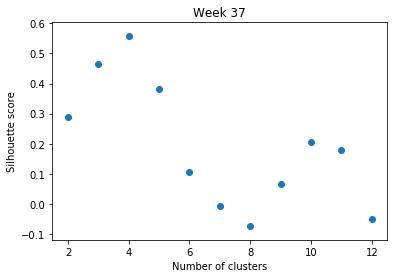

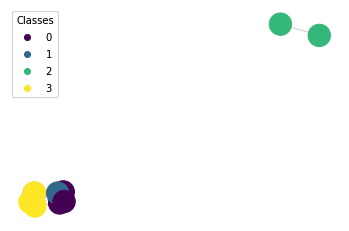

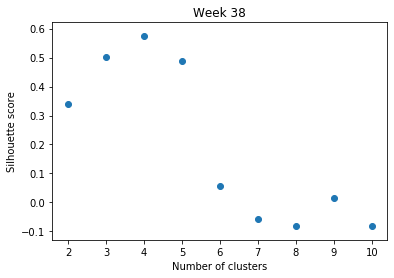

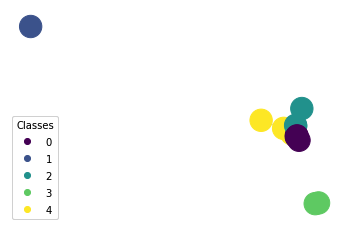

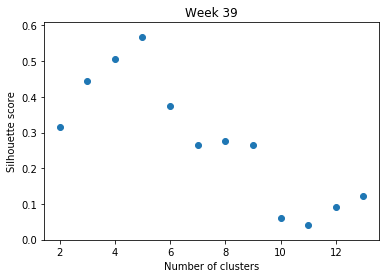

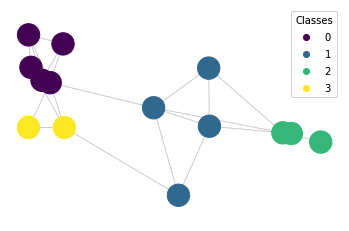

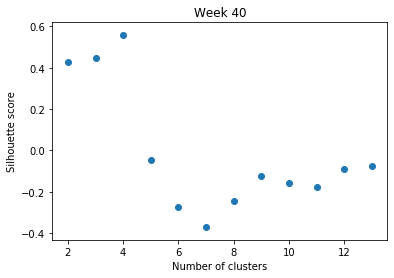

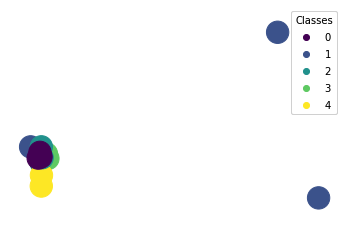

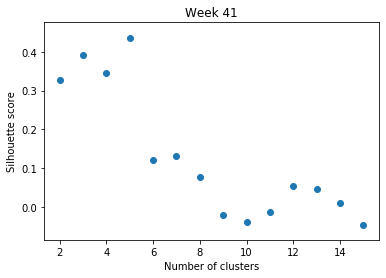

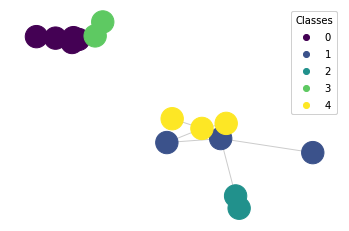

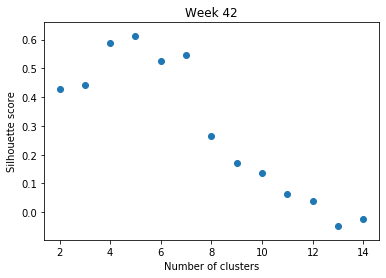

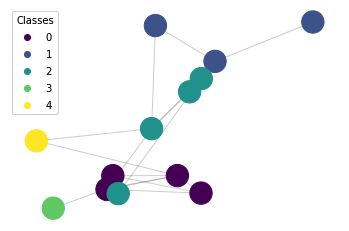

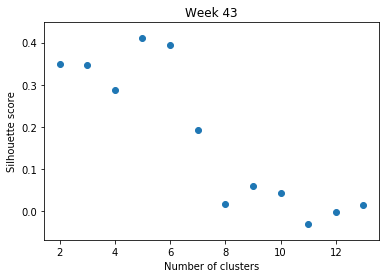

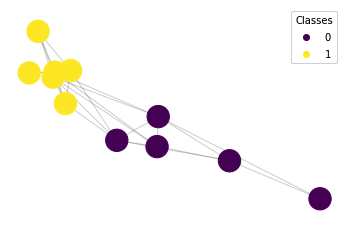

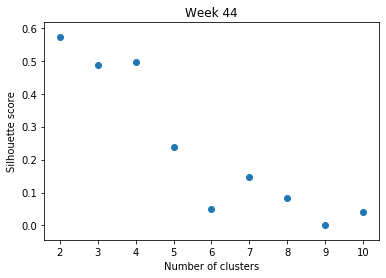

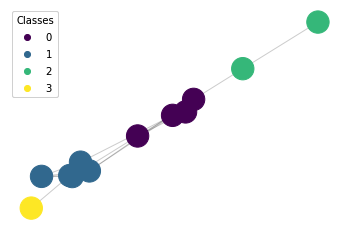

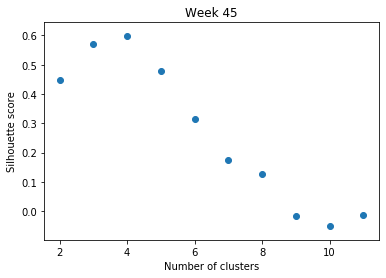

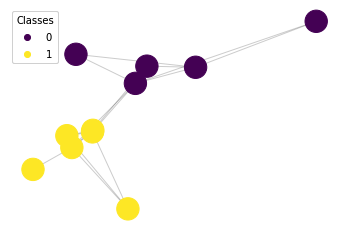

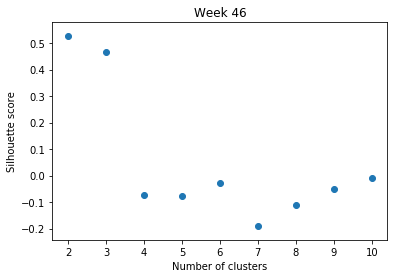

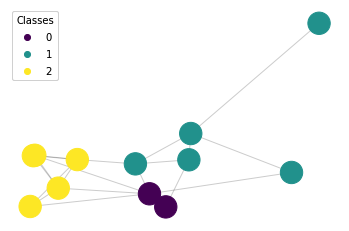

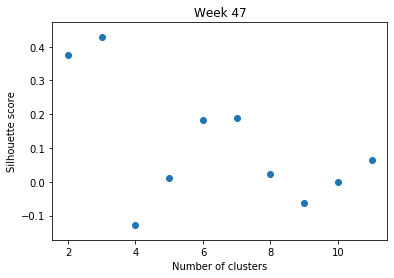

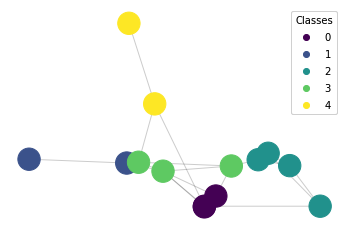

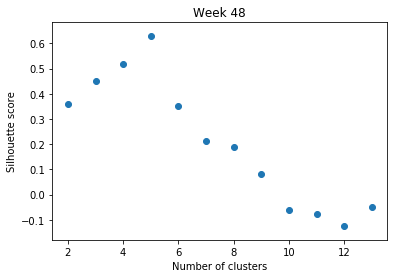

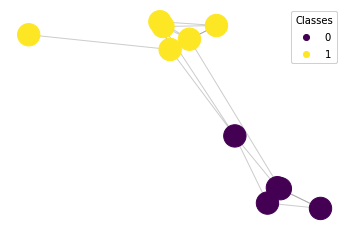

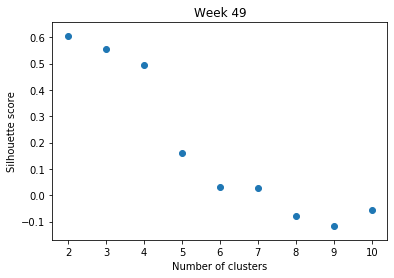

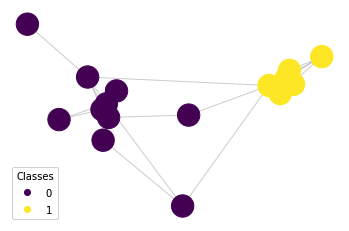

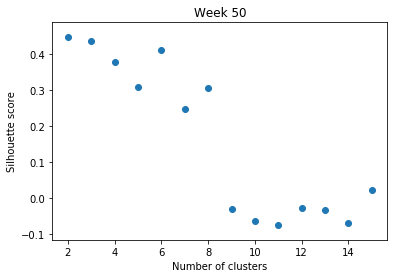

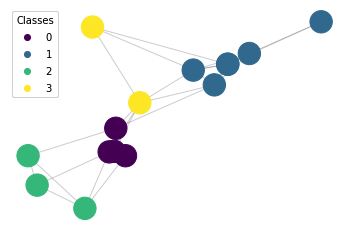

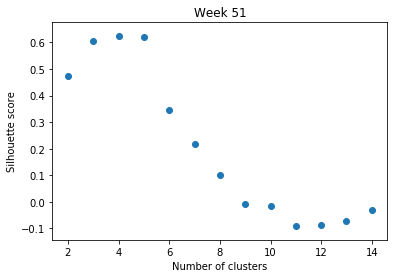

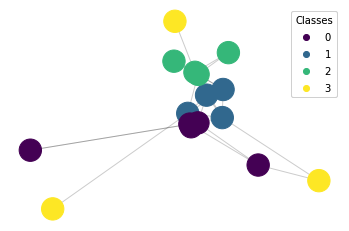

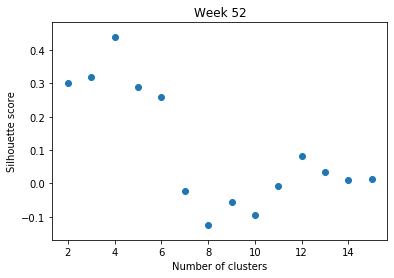

In [5]:
# column_names = ['file', 'best_clusters', 'max_score', 'scores', 'all_clusters']
# df1 = pd.DataFrame(columns=column_names)
df1 = pd.DataFrame({'file': [], 'best_clusters': [], 'scores': [], 'all_clusters': []})
for f in files:
    g = nx.read_graphml(f[1])
    week_n = str(f[0])
    X = preprocess(g)
    clust_lab, max_score, scores, all_labels = cluster_score(X, g)
    
    # save clusters to file
    df2 = pd.DataFrame({'file': [week_n], 'best_clusters': [clust_lab],
                       'max_score': [max_score], 'scores': [scores],
                      'all_clusters': [all_labels]})
    df1 = pd.concat([df1, df2])
    
    plt.figure()
    plt.scatter(np.arange(2, len(scores)+2), scores)
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette score")
    plt.title("Week " + week_n)
    plt.show()

df1 = df1.reset_index()
df1.to_pickle('clusters-kmeans.pkl')

In [6]:
df = pickle.load(open("clusters-kmeans.pkl", "rb"))

In [7]:
df.head()

,index,file,best_clusters,scores,all_clusters,max_score
0,0,1,"[0, 0, 2, 1, 4, 2, 4, 0, 2, 2, 2, 4, 1, 3, 3]","[0.19886343941026297, 0.2974190119730896, 0.38...","[[0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]...",0.505288
1,0,2,"[1, 1, 0, 2, 3, 0, 2, 1, 0, 0, 2, 2, 3, 3]","[0.31539786735429803, 0.3669271996259714, 0.43...","[[1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0], [...",0.436213
2,0,3,"[0, 0, 1, 5, 3, 2, 4, 0, 4, 2, 2, 5, 5, 1, 1]","[0.22781465893931005, 0.21784906286245084, 0.2...","[[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0]...",0.346022
3,0,4,"[2, 0, 0, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1]","[0.29166384387680233, 0.35032450347340693, 0.2...","[[1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,...",0.350325
4,0,5,"[2, 3, 0, 4, 4, 1, 0, 1, 1, 3, 4, 2, 2, 2, 0, 3]","[0.3086457469753182, 0.3870443708755874, 0.478...","[[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,...",0.523102


In [8]:
def d_mat(g):
    A = nx.to_numpy_matrix(g)
    A = 1/(1+np.log(A + 1))
    np.fill_diagonal(A, 0)
    return A

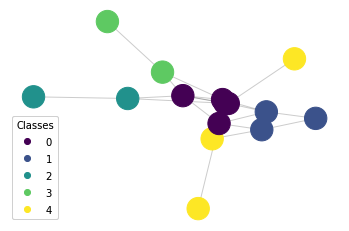

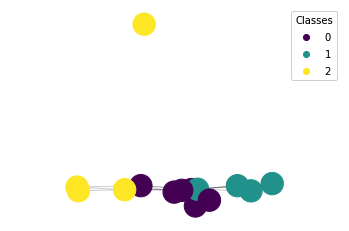

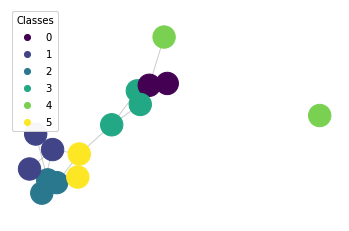

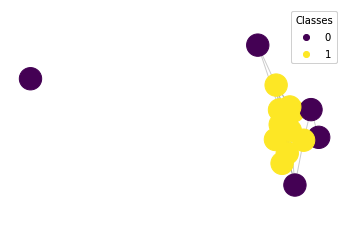

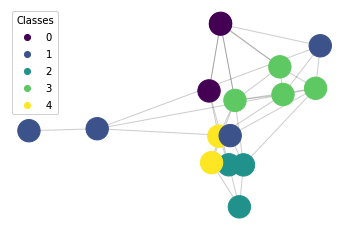

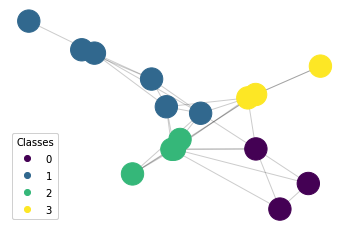

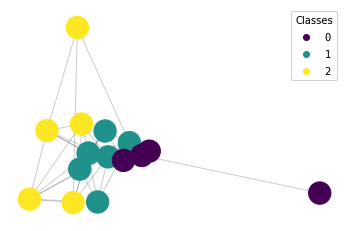

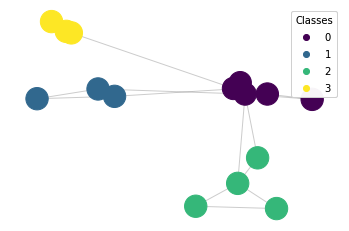

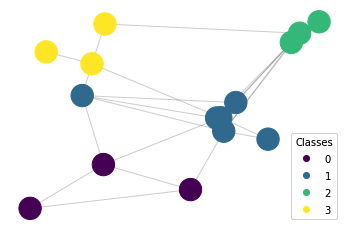

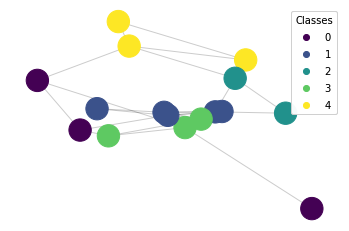

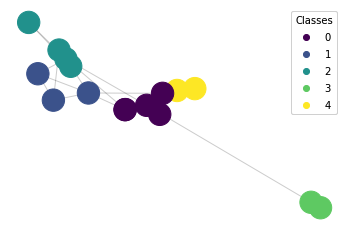

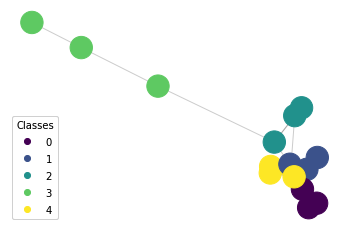

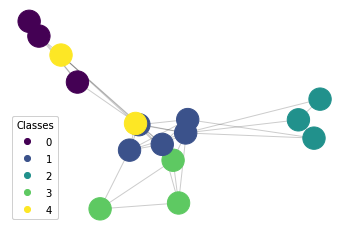

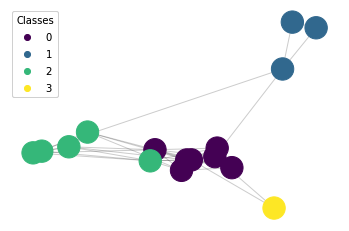

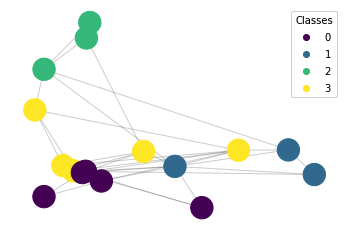

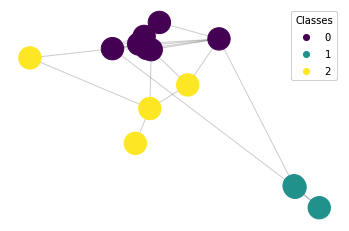

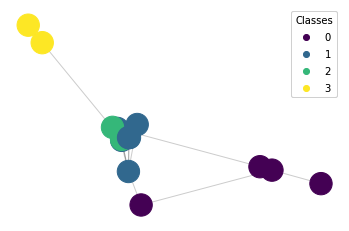

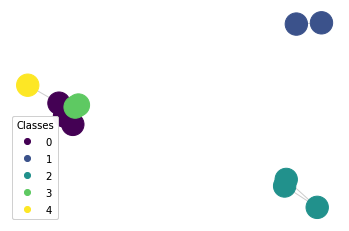

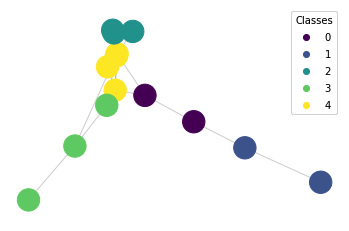

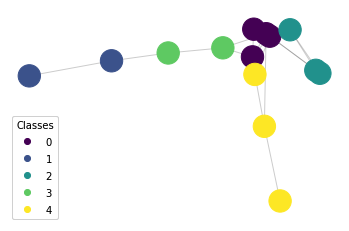

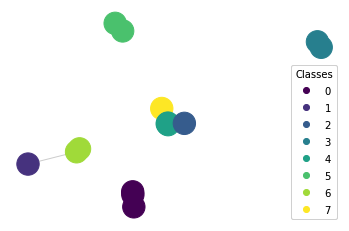

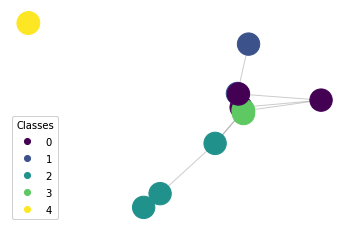

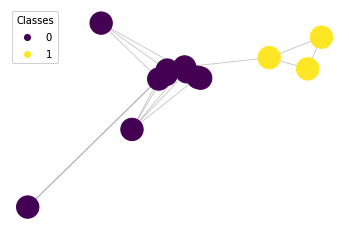

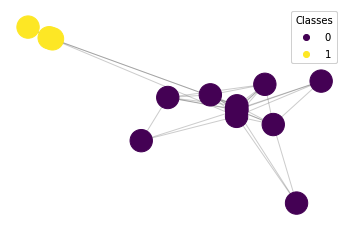

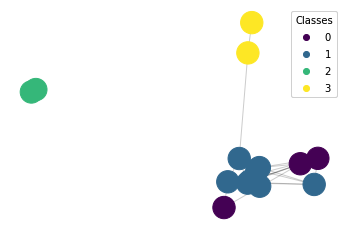

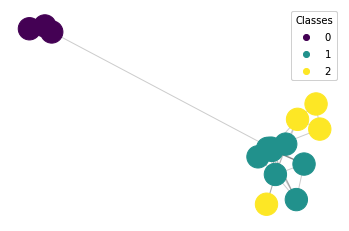

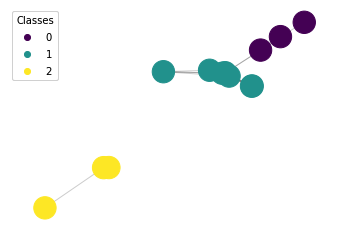

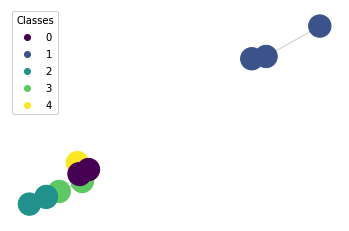

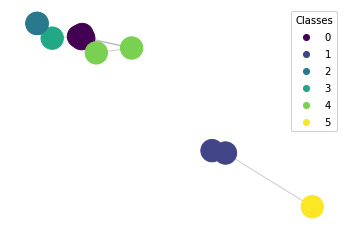

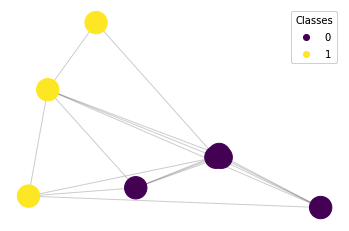

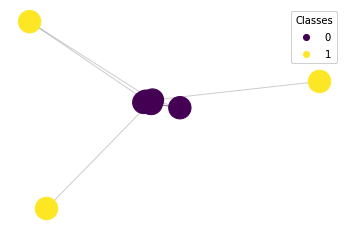

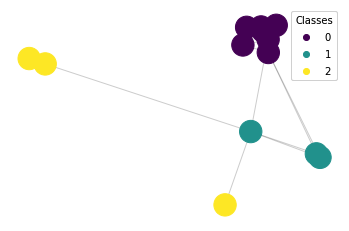

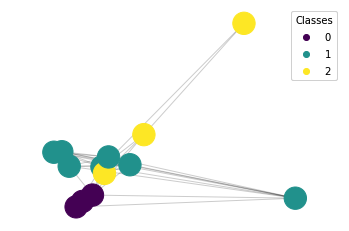

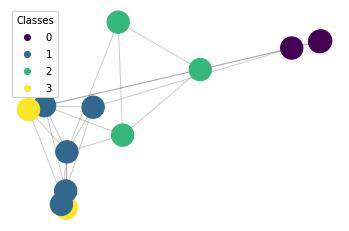

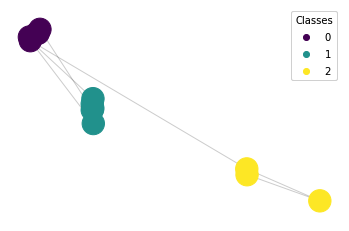

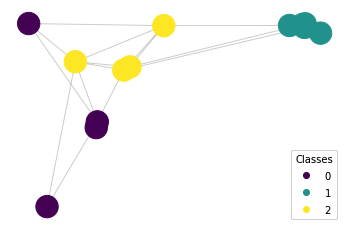

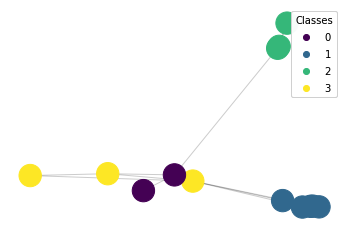

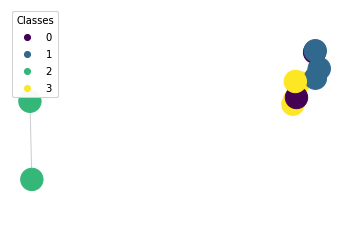

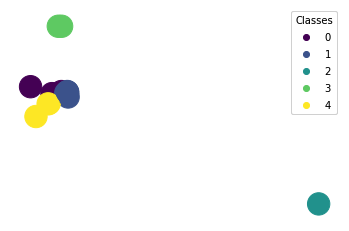

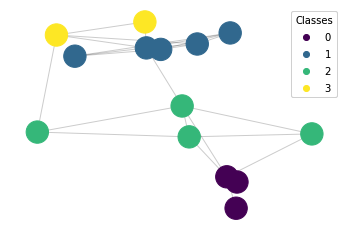

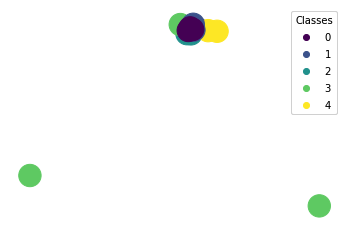

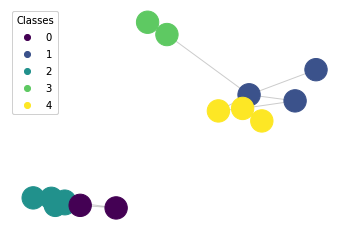

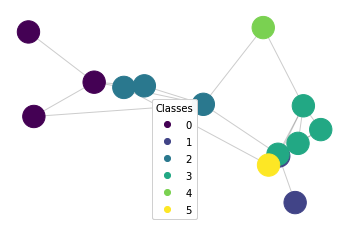

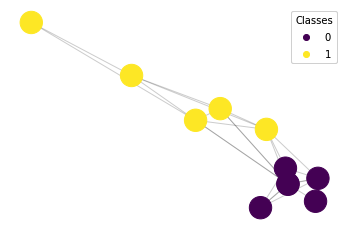

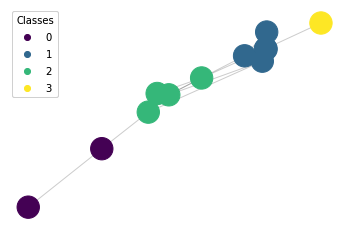

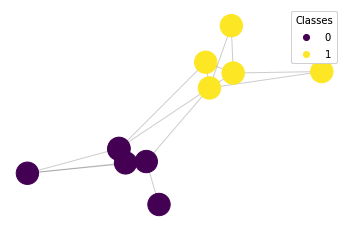

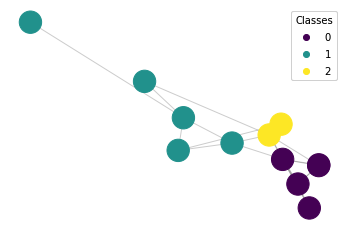

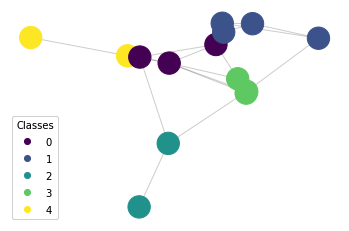

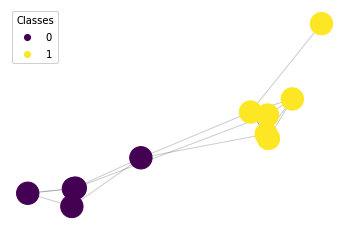

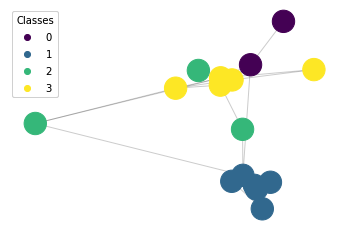

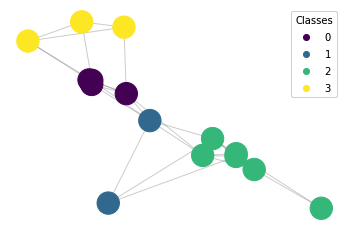

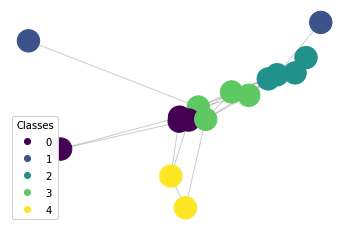

In [9]:
filt = [str(x) for x in range(16)]

clusters = []
for f in files:
    G = nx.read_graphml(f[1]).subgraph(filt)
    x1, _, x2, _ = cluster_score(d_mat(G), G)
    clusters.append([x1,x2])

In [10]:
scores = {i:clusters[i][1] for i in range(len(clusters))}

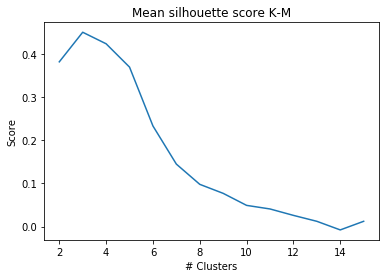

In [20]:
for j in scores:
    scores[j] = {i:scores[j][i] for i in range(len(scores[j]))}
plt.plot(range(2, 16), pd.DataFrame(scores).mean(axis=1))
plt.title('Mean silhouette score K-M')
plt.xlabel('# Clusters')
plt.ylabel('Score')
plt.show()

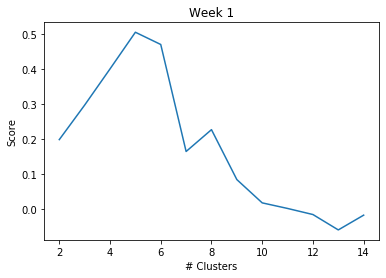

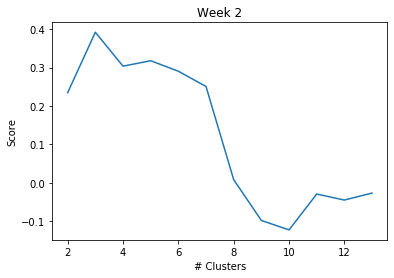

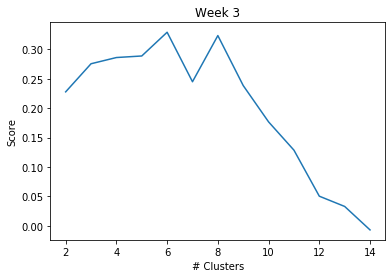

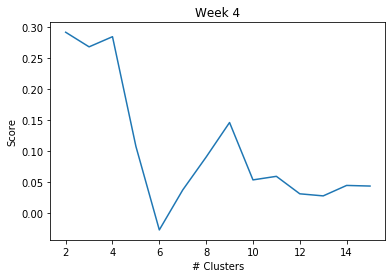

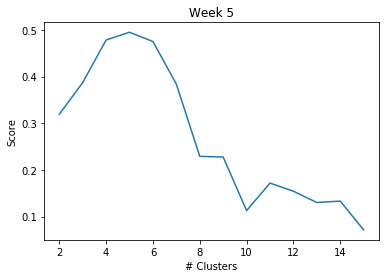

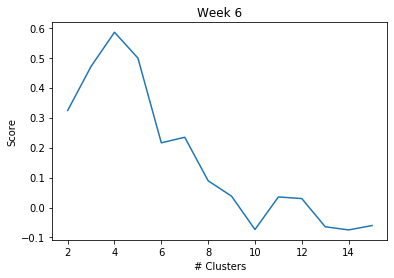

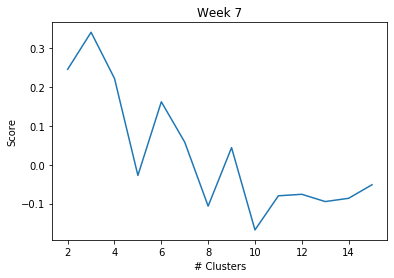

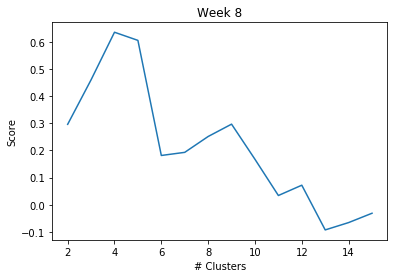

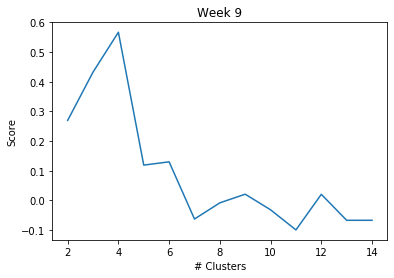

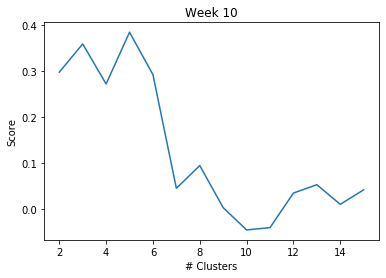

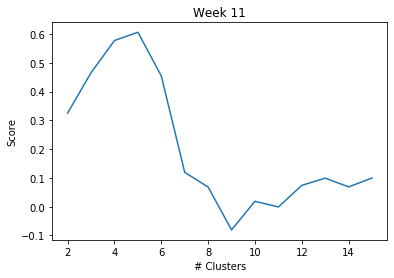

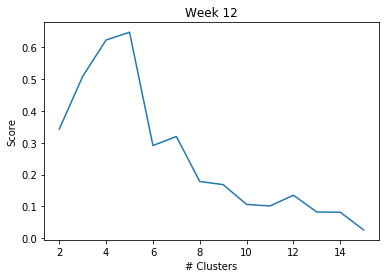

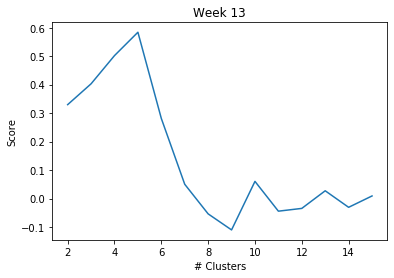

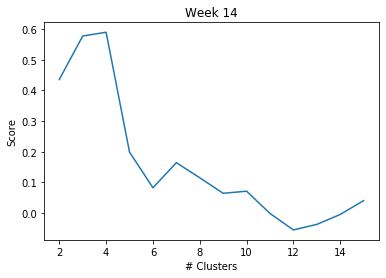

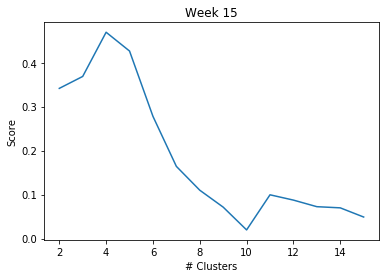

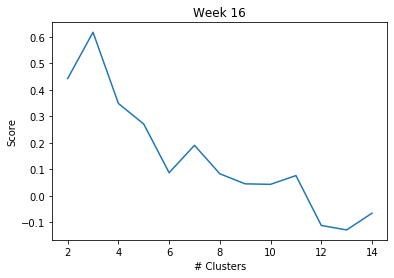

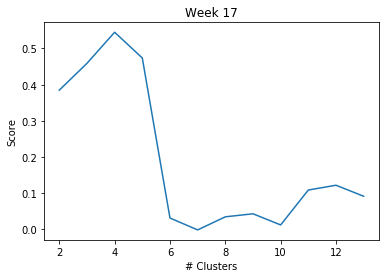

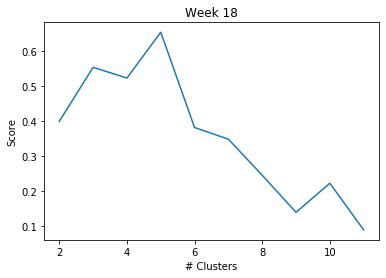

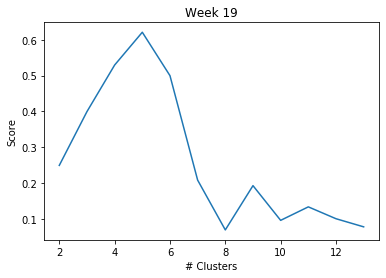

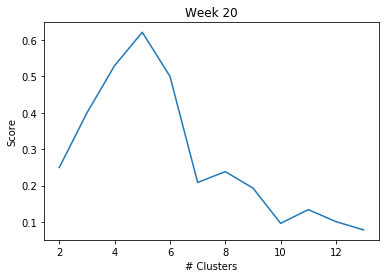

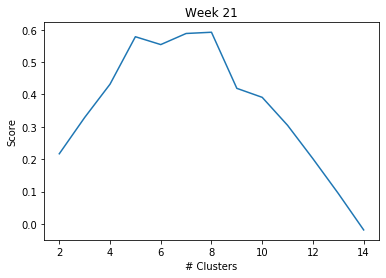

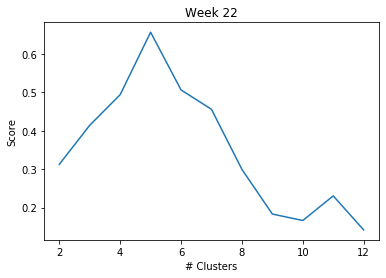

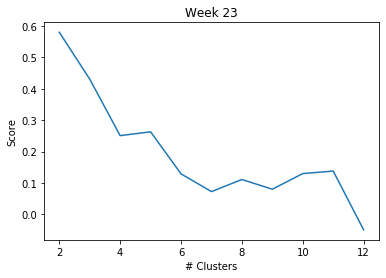

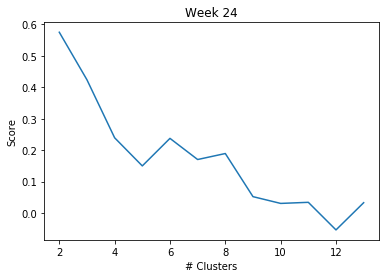

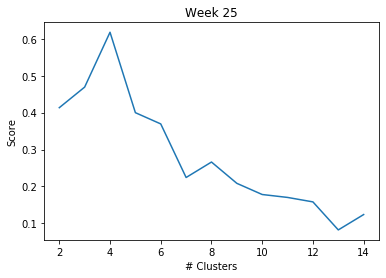

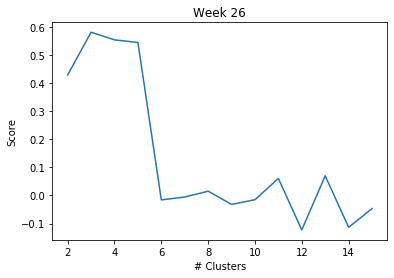

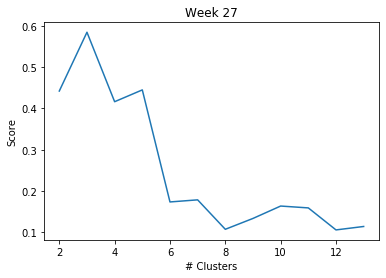

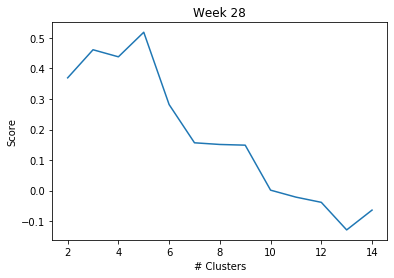

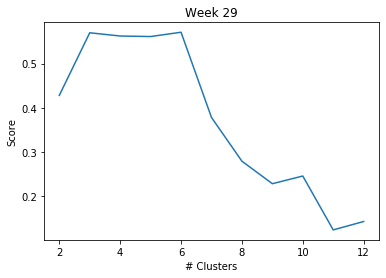

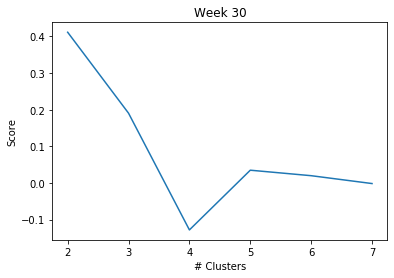

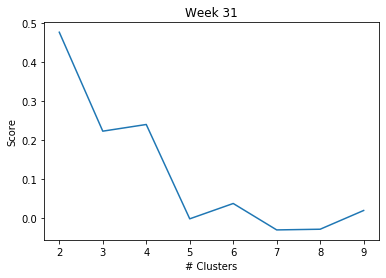

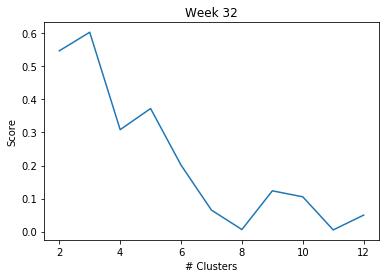

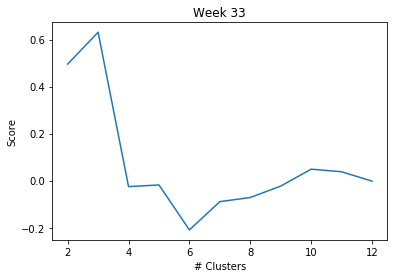

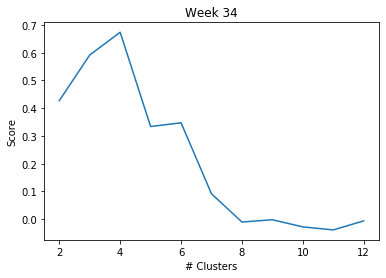

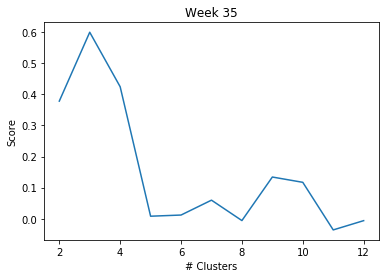

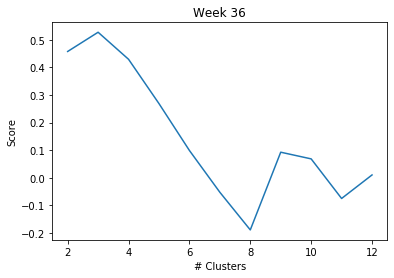

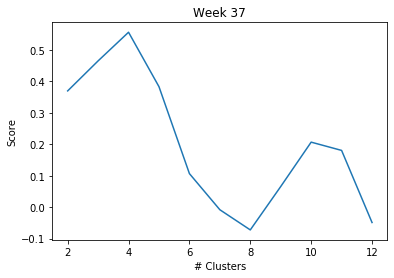

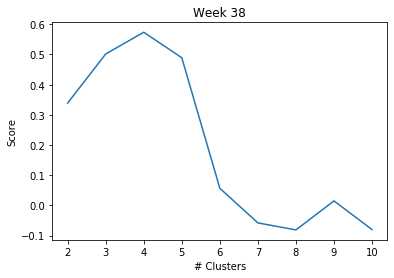

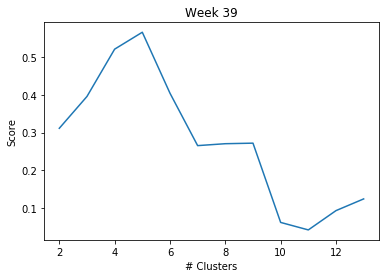

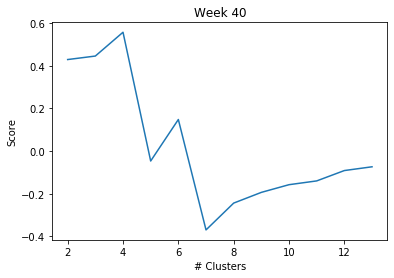

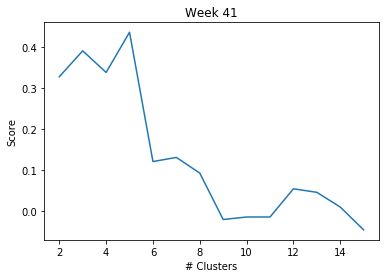

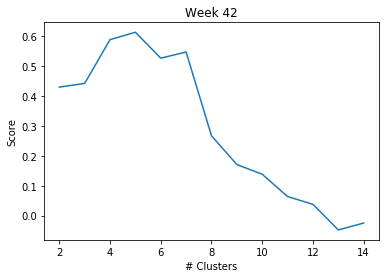

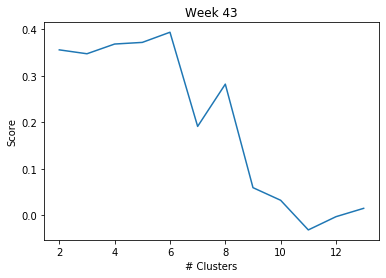

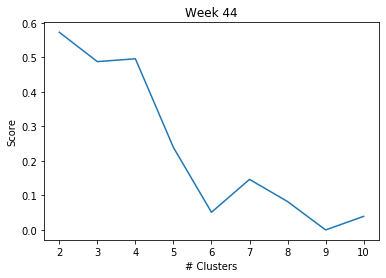

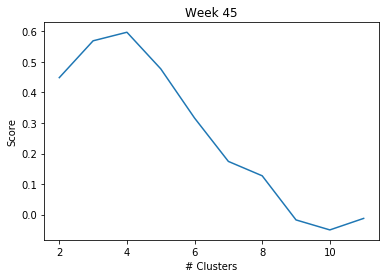

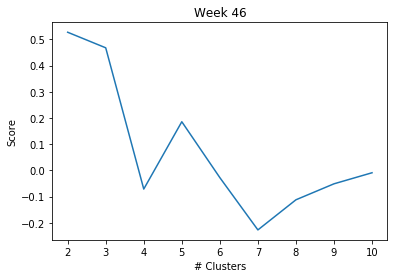

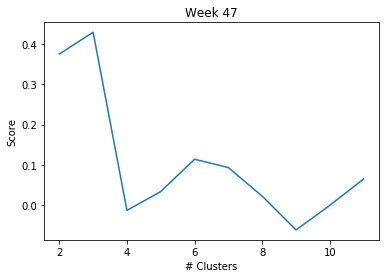

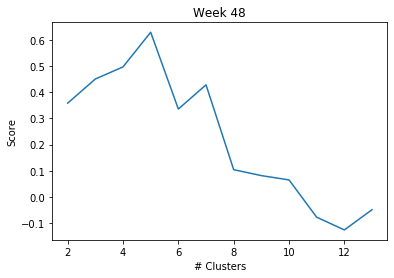

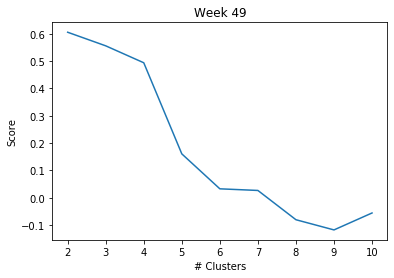

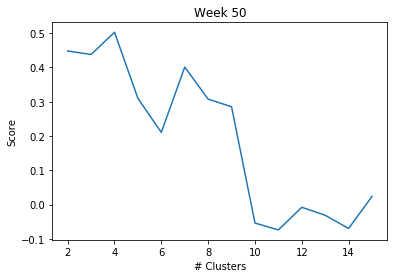

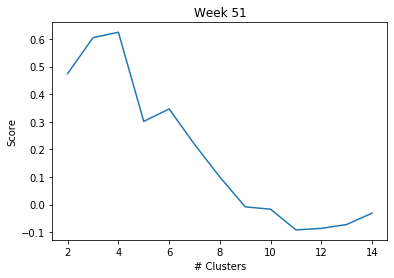

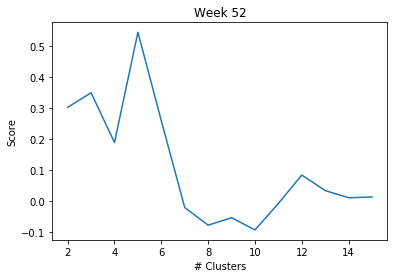

In [12]:
i=1
for s in scores:
    plt.plot(range(2, len(list(scores[s].values())) + 2), list(scores[s].values()))
    plt.title('Week ' + str(i))
    plt.xlabel('# Clusters')
    plt.ylabel('Score')
    plt.show()
    i += 1

To do:

Get total number of cluster IDs per ID.
Plot histogram for all IDs.

In [13]:
def cluster_score(X, g):
    scores = []
    labels = []
    for i in range(2, len(X)):
        kmeans_model = KMeans(n_clusters=i, precompute_distances=True).fit(X)
        l = kmeans_model.labels_
        s = silhouette_score(X, l, metric="precomputed")
        scores.append(s)
        labels.append(l)
    
    idx = np.argmax(scores)
    clust_lab = {list(g.nodes())[i]:list(labels[idx])[i] for i in range(len(labels[idx]))}
    return clust_lab, scores
    #return clust_lab, np.asarray(scores)

In [25]:
clusters = []
for f in files:
    G = nx.read_graphml(f[1]).subgraph(filt)
    clusters.append(cluster_score(d_mat(G), G))

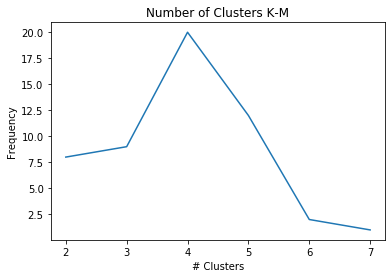

In [24]:
from collections import Counter
n_clust = [max(c[0].values()) + 1 for c in clusters]
n_clust = Counter(n_clust)
k = sorted(n_clust)
n_clust = [n_clust[x] for x in k]
plt.plot(k, n_clust)
plt.title('Number of Clusters K-M')
plt.xlabel('# Clusters')
plt.ylabel('Frequency')
plt.show()

In [14]:
import plotly.graph_objects as go

final_pos = pd.read_csv('final_pos.csv', index_col='index')
final_pos.index = final_pos.index.map(str)
final_pos = dict(final_pos.apply(lambda x: np.array([x[0], x[1]]), axis=1))

def create_edges(G, pos):
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')
    return edge_trace

def create_nodes(G, pos):
    node_x = [-1]
    node_y = [-1]
    for p in pos.values():
        x, y = p
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(size=20,
            line_width=2))

    node_adjacencies = [-1]
    node_text = ['na']
    c, xx = cluster_score(d_mat(G), G)
    for k in pos.keys():
        if k in G.nodes:
            node_adjacencies.append(c[k])
            node_text.append('Cluster: '+str(c[k]))
        else:
            node_adjacencies.append(-1)
            node_text.append('Cluster: NA')

    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text
    return node_trace

In [15]:
import plotly
plotly.offline.init_notebook_mode(connected=True)

In [16]:
weeks = list(range(1, 53))
x = [x[0] for x in final_pos.values()]
y = [x[1] for x in final_pos.values()]
# make figure
G = nx.read_graphml(files[0][1]).subgraph(filt)
fig_dict = {
    "data": [create_edges(G, final_pos), create_nodes(G, final_pos)],
    "layout": {},
    "frames": []
}

# fill in most of layout
fig_dict["layout"]['title'] = '<br>Evolution of clusters through time'
fig_dict["layout"]['titlefont_size'] = 16
fig_dict["layout"]['showlegend'] = False
fig_dict["layout"]['hovermode'] = 'closest'
fig_dict["layout"]['margin'] = dict(b=20,l=5,r=5,t=40)
fig_dict["layout"]['xaxis'] = dict(showgrid=False, zeroline=False, showticklabels=False,
                                   range=[min(x)*1.1, max(x)*1.1])
fig_dict["layout"]['yaxis'] = dict(showgrid=False, zeroline=False, showticklabels=False,
                                   range=[min(y)*1.1, max(y)*1.1])

fig_dict["layout"]["sliders"] = {
    "args": [
        "transition", {
            "duration": 400,
            "easing": "cubic-in-out"
        }
    ],
    "initialValue": "1",
    "plotlycommand": "animate",
    "values": weeks,
    "visible": True
}
fig_dict["layout"]["updatemenus"] = [
    {
        "buttons": [
            {
                "args": [None, {"frame": {"duration": 1000, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 300,
                                                                    "easing": "quadratic-in-out"}}],
                "label": "Play",
                "method": "animate"
            },
            {
                "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                  "mode": "immediate",
                                  "transition": {"duration": 0}}],
                "label": "Pause",
                "method": "animate"
            }
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 87},
        "showactive": False,
        "type": "buttons",
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }
]

sliders_dict = {
    "active": 0,
    "yanchor": "top",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": 20},
        "prefix": "Week:",
        "visible": True,
        "xanchor": "right"
    },
    "transition": {"duration": 300, "easing": "cubic-in-out"},
    "pad": {"b": 10, "t": 50},
    "len": 0.9,
    "x": 0.1,
    "y": 0,
    "steps": []
}

#Update the data and frames

for f in files:
    G = nx.read_graphml(f[1]).subgraph(filt)
    frame = {"data": [create_edges(G, final_pos), create_nodes(G, final_pos)], "name": f[0]}
    fig_dict["frames"].append(frame)
    slider_step = {"args": [
        [f[0]],
        {"frame": {"duration": 300, "redraw": False},
         "mode": "immediate",
         "transition": {"duration": 300}}
    ],
        "label": f[0],
        "method": "animate"}
    sliders_dict["steps"].append(slider_step)
    
fig_dict["layout"]["sliders"] = [sliders_dict]

fig = go.Figure(fig_dict)

fig.show()

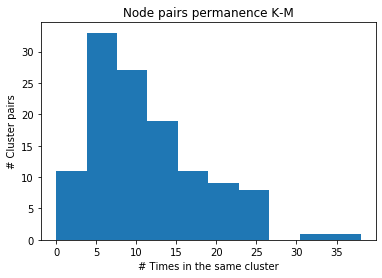

In [26]:
cl_pairs = {(str(n), str(nn)):0 for n in range(15) for nn in range(n + 1, 16)}
for k in clusters:
    for i in range(len(k[0])):
        for j in range(i + 1, len(k[0])):
            if list(k[0].values())[i]==list(k[0].values())[j]:
                cl_pairs[list(k[0].keys())[i], list(k[0].keys())[j]] += 1
plt.hist(cl_pairs.values())
plt.title('Node pairs permanence K-M')
plt.xlabel('# Times in the same cluster')
plt.ylabel('# Cluster pairs')
plt.show()

In [17]:
plotly.__version__

'4.5.0'

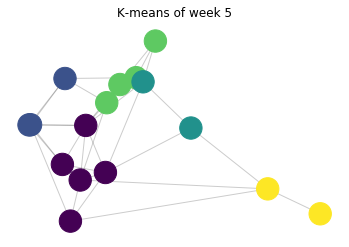

In [19]:
G = nx.read_graphml(files[4][1]).subgraph(filt)
cl, sc = cluster_score(d_mat(G), G)
p = pd.read_csv('pos_w5.csv', index_col=0)
p.index = p.index.map(str)
p = dict(p.apply(lambda x: np.array([x[0], x[1]]), axis=1))
nx.draw_networkx_nodes(G, p, node_color=list(cl.values()), node_size=500, label=G.nodes())
nx.draw_networkx_edges(G, p, alpha=0.2)
plt.axis('off')
plt.title('K-means of week 5')
plt.show()